In [1]:
# LIBRERIAS
import matplotlib
from ipywidgets.widgets.widget_string import Label
from ipywidgets import interact,widgets
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits import mplot3d
import math
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
%matplotlib inline 
#matplotlib.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20) 
font = {'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

#plt.style.use('Solarize_light2')
import seaborn as sns
import os
#to en otra carpeta

path=os.getcwd()
sns.set_theme()

In [7]:
c = 299792458;            #speed of light [m/s]

def propagar():
    
    #Constants
    n = 2**13  # number of grid points
    TimeWindow = 12.5e-12 # width of time window [s]     
    dT = TimeWindow/n
    TimeGrid =  np.arange(-n/2,n/2,1)*dT #  time grid
    WaveLength=835e-9      #reference wavelength [m]
    w0 = (2*np.pi*c)/WaveLength  #reference frequency [Hz]
    t0 =28.4e-15       # duration of input [s]
    power = 10000      #peak power of input [W]
    A = np.sqrt(power)*1/np.cosh(TimeGrid/(t0))*np.cos(w0*TimeGrid) # input field [W^(1/2)]
  
    #Fiber parameters 
    length = 0.15            #ibre length [m]

    #betas = [beta2, beta3, ...] in units [s^2/m, s^3/m ...]
    betas = [-1.1830e-26, 8.1038e-41, -9.5205e-56,  2.0737e-70,
         -5.3943e-85,  1.3486e-99, -2.5495e-114,  3.0524e-129, 
         -1.7140e-144]
    gamma =0.11  #nonlinear coefficient [1/W/m]
    loss = 0.0e-3       #loss [dB/m]

    
    #Raman response
    fr = 0.18               # fractional Raman contribution
    tau1 =  0.0122e-12; tau2 =  0.032e-12;
    #fb=0.21 ; taub=96e-12 

    # Response function modified
    
    RT=(tau1**2+tau2**2)/(tau1*tau2**2)*np.exp(-TimeGrid/tau2)*np.sin(TimeGrid/tau1) # Response function
    RT[TimeGrid<0]=0
      #+fb*(2*taub-TimeGrid)/taub**2*np.exp(-TimeGrid/taub))
    #WN=np.array([0.01060,0.01884,0.04356,0.06828,0.08721,0.09362,0.11518,0.13029,0.14950,0.15728,0.17518,0.20343,0.22886])/1e-15
    #An=np.array([1,11.4,36.67,67.67,74,4.5,6.8,4.6,4.2,4.5,2.7,3.1,5.02])
    
    #gamn=np.array([1.64,3.66,5.49,5.10,4.25,0.77,1.30,4.87,1.87,2.02,4.71,2.86,5.02])*1e-3/1e-15
    #Gamn=np.array([4.91,10.4,16.48,15.3,12.75,2.31,3.91,14.60,5.6,6.06,14.13,8.57,15.07])*1e-3/1e-15


    #RT=[sum(An[i]*np.exp(-gamn[i]*t-Gamn[i]**2*t**2/4)*np.sin(WN[i]*t) for i in range(len(An))) for t in TimeGrid]

    RT[TimeGrid<0]=0

    hr=RT/np.trapz(RT, TimeGrid)
    fw =np.fft.ifft((A))
    n = len(TimeGrid); dT = TimeGrid[2]-TimeGrid[1]
    V=2*np.pi*np.arange(-n/2,n/2,1).T/(n*dT)  # frequency grid
    alpha = np.log(10.**(loss/10))   #attenuation coefficient
    B = 0

    for i in range(0,len(betas)):      #Taylor expansion of betas
        B = B + betas[i]/math.factorial(i+2)*V**(i+2)

    L=1j*B - alpha/2
    gamma = gamma/w0   
    W = V + w0  
    HW =np.fft.ifft(np.fft.fftshift(hr.T))*n   # frequency domain Raman
    L=np.fft.fftshift(L) 
    W=np.fft.fftshift(W) 

    #Ecuación a integrar.
    def rhs(z,AW):

        AT=np.fft.fft(np.exp(L*z)*AW) #A TILDE

        IT=np.abs(AT)**2

        AA=np.fft.ifft(IT) #Fourier transform of IT

        RS= fr*np.fft.fft(HW*AA)*dT # Convolution

        M=np.fft.ifft(AT*((1-fr)*IT + RS))  #% response function

        return 1j*gamma*W*M*np.exp(-L*z)

    nsaves=200  # Number of points along the distance

    # Z
    z= np.linspace(0,length,nsaves)

    # solve ODE
    y = solve_ivp(rhs,[min(z),max(z)],fw,t_eval=z)

    for i in range(0,len(y.y[0,:])):
    # change variables, frequency solutions.
        y.y[:,i] = np.fft.fftshift(y.y[:,i]*np.exp(L.T*z[i]))*dT*n 
    
    W = V + w0
    WL = (2*np.pi*c/W) #iis = (WL>400 & WL<1350); % wavelength grid
    N1=400e-9;N2=1300e-9
    iis=np.array([(i>N1 and i<N2) for i in WL])
    lIW = 10*np.log10(np.abs(y.y.T)**2)
   
    return lIW[:,iis][-1], WL[iis]*1e9

/tmp/ipykernel_51672/823701280.py:96: RuntimeWarning: divide by zero encountered in log10
  lIW = 10*np.log10(np.abs(y.y.T)**2) #2*np.pi*c/WL**2) # log scale spectral intensity


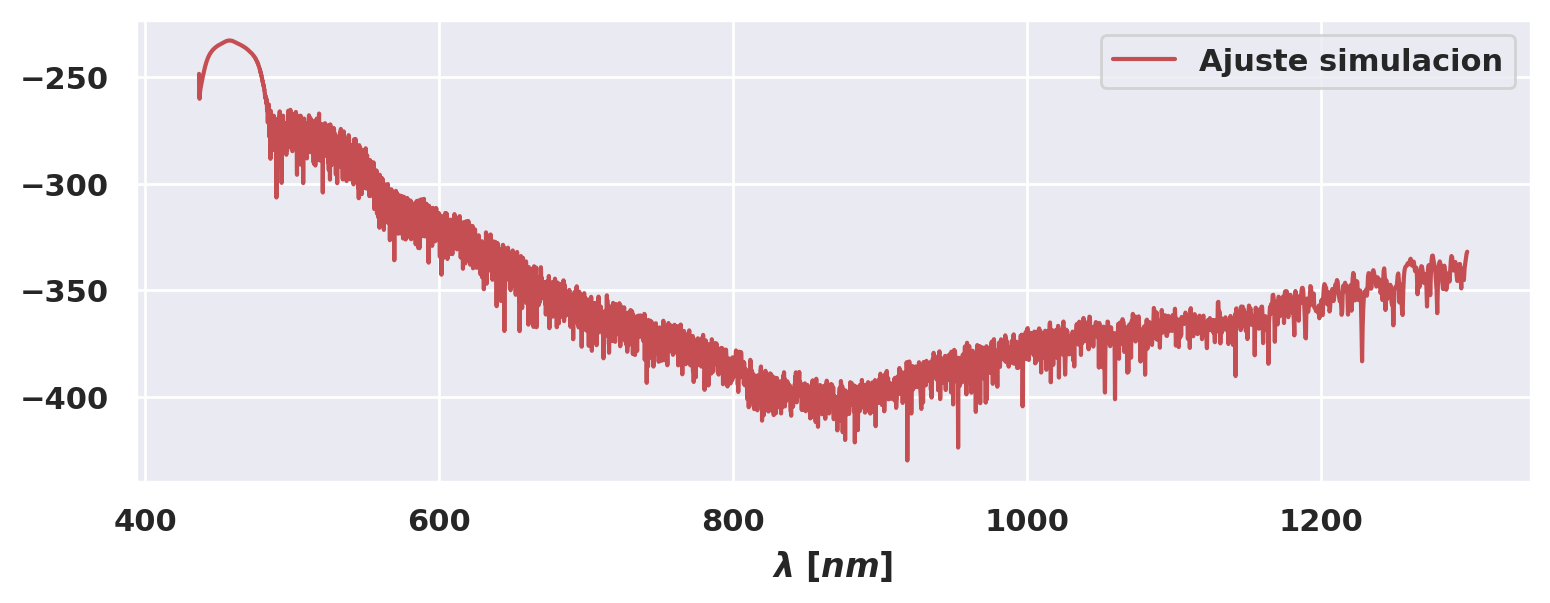

In [8]:
f = plt.figure(figsize=(9, 3),dpi=200)
yy,WL=propagar()
plt.plot(WL,yy,'r',label='Ajuste simulacion')

plt.xlabel('$\lambda$ $[nm]$')
#plt.title(str(round(z[-1],3))+' [m]')
#plt.ylabel('Normalized Intensity (a.u)' )
#plt.xlim(1300,1800)
plt.legend()
